## Exploratory Data Analysis

[Датасет физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones).

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано на [страничке датасета](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex

import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1qv0TIapvCW0NBgfgv6ii4R4ep60EEgGQ')
test = pd.read_csv("https://drive.google.com/uc?export=download&id=1F2ocQUpBya3yddZyRcjCenXAhEQAPYVn")

В датасете 563 признака, сделаем подвыборку признаков для удобства работы с ними.

In [7]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [8]:
train = train[cols_subset]
test = test[cols_subset]

In [13]:
train.describe()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,-0.543884,-0.727735,0.678505,-0.468604,-0.847963,-0.489547,0.058593,-0.056515,-0.128562,17.413085
std,0.477653,0.315832,0.508656,0.544547,0.233633,0.511807,0.297480,0.279122,0.403686,8.975143
min,-1.000000,-0.999889,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.931208,1.000000
25%,-0.983282,-0.991595,0.804270,-0.936219,-0.999480,-0.812065,-0.017885,-0.143414,-0.486841,8.000000
50%,-0.883371,-0.950268,0.926693,-0.881637,-0.986582,-0.709417,0.182071,0.003181,-0.163271,19.000000
75%,-0.106892,-0.474625,0.965095,-0.017129,-0.764508,-0.509079,0.248353,0.107659,0.155112,26.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.478157,1.000000,1.000000,30.000000


Можно заметить, что почти все переменные имеют довольно большие стандартные отклонения, что говорит о большом разбросе значений в данных. $\\$
К тому же, значения медианы сильно отличаются от средних значений, что снова наталкивает нас на мысль о  большом раздросе данных.

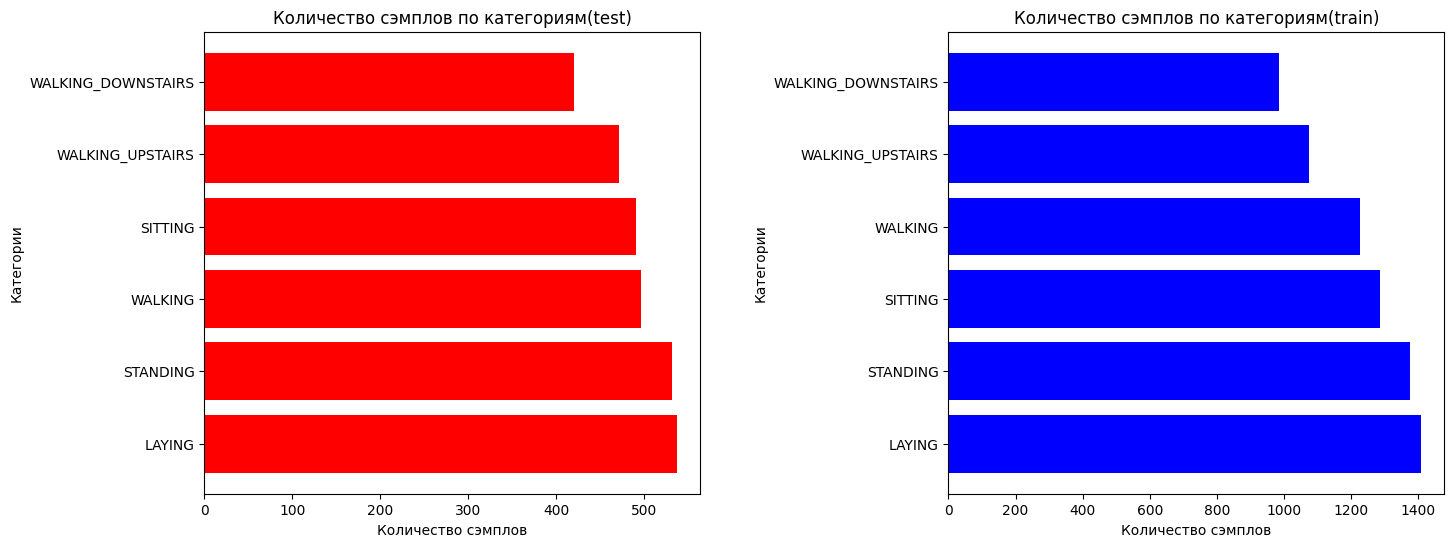

In [21]:
train_samples = train['Activity'].value_counts() 
test_samples = test['Activity'].value_counts()
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.barh(test_samples.index, test_samples.values, color='r')
plt.title("Количество сэмплов по категориям(test)")
plt.xlabel('Количество сэмплов')
plt.ylabel('Категории')  

plt.subplot(1, 2, 2)
plt.barh(train_samples.index, train_samples.values, color='b')
plt.title("Количество сэмплов по категориям(train)")
plt.xlabel('Количество сэмплов')
plt.ylabel('Категории')  
plt.subplots_adjust(wspace=0.5)
plt.show()

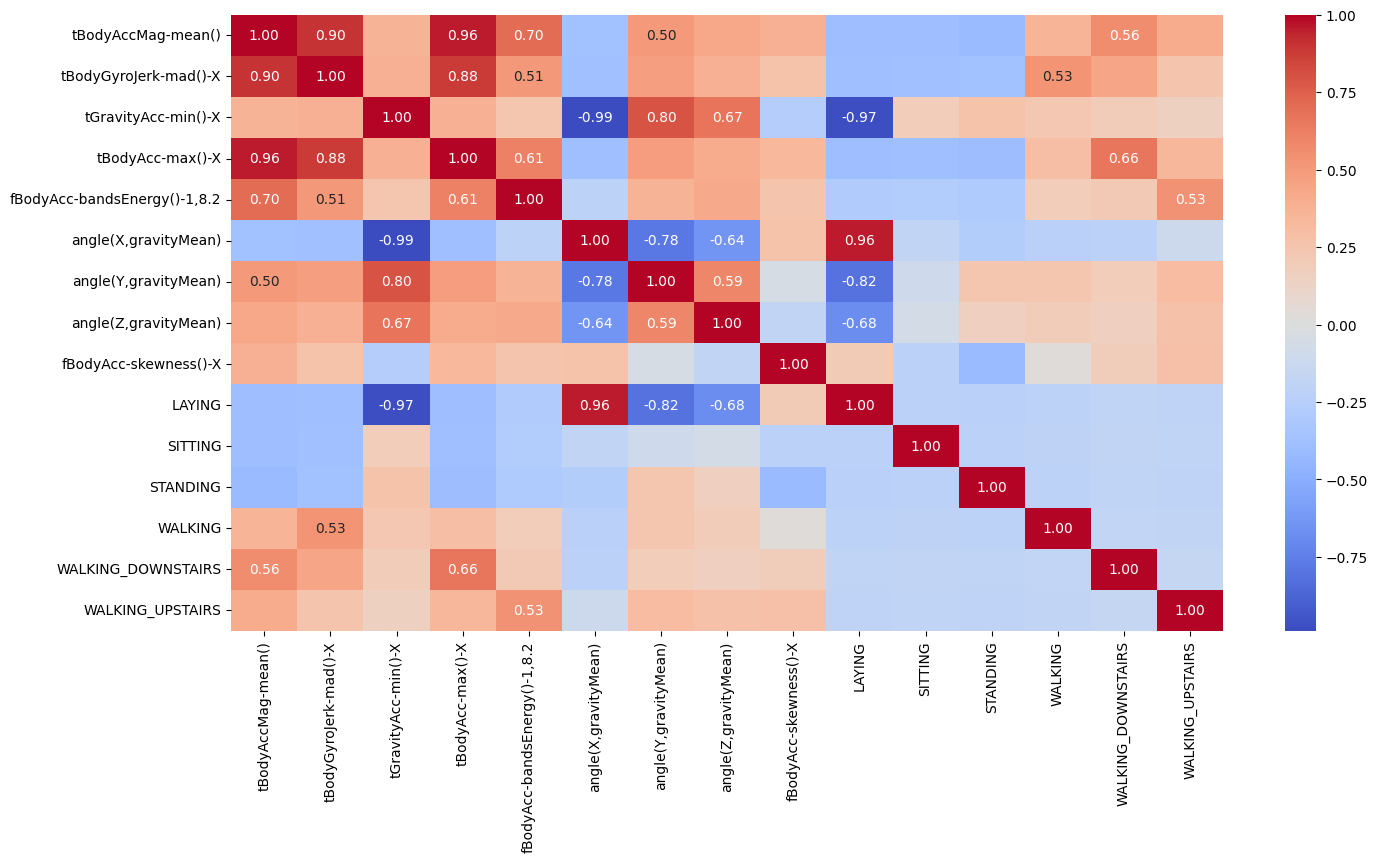

In [22]:
train_encoded = pd.get_dummies(train, columns=['Activity'], prefix='', prefix_sep='')
plt.figure(figsize=(16,8))
ax = sns.heatmap(train_encoded.drop(['subject'], axis=1).corr(), cmap="coolwarm", annot=True, fmt="0.2f")
for t in ax.texts:
    if float(t.get_text()) >= 0.5 or float(t.get_text()) <= -0.5:
        t.set_text(t.get_text())
    else:
        t.set_text("")

Можно заметить, что усредненная величина ускорения тела коррелирует с большим положительным коэффициентом с медианной величиной рывка, что может означать что большое ускорение тела приводит к большой величине рывка.\
Аналогичная ситуации с максимальной величиной ускорения и медианной величиной рывка.\
Также вполне объясним большой положительный коэффициент корреляции усредненной и максимальной величин ускорения, потому что, очевидно, они обе зависят линейно только от самих величин ускорений.\
Вполне объясним большой положительный коэффициент корреляции между усредненнйо величиной ускорения и энергией ускорения тела в интервале частоты: большее ускорение означает большую энергию.



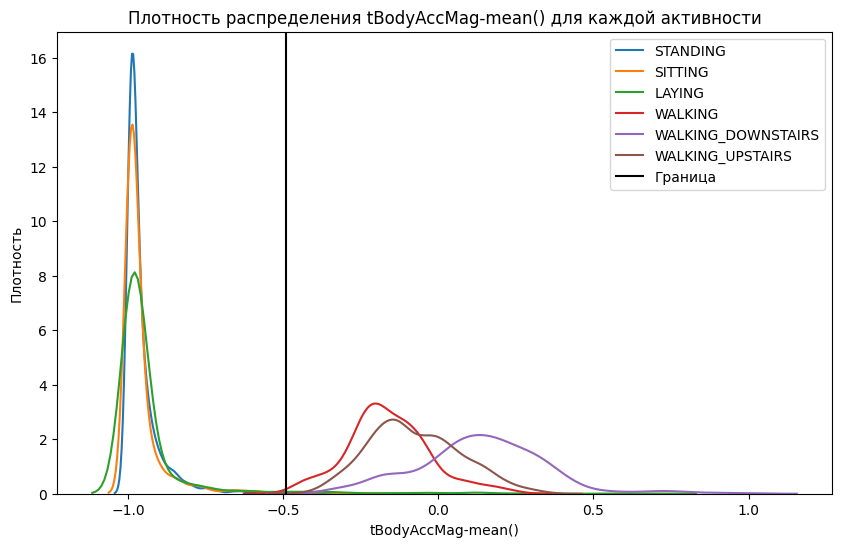

In [26]:
plt.figure(figsize=(10, 6))
for activity in train['Activity'].unique():
    sns.kdeplot(train[train['Activity'] == activity]['tBodyAccMag-mean()'], label=activity)

plt.axvline(-0.49, color='black', label='Граница')
plt.title('Плотность распределения tBodyAccMag-mean() для каждой активности')
plt.xlabel('tBodyAccMag-mean()')
plt.ylabel('Плотность')
plt.legend()
plt.show()

In [27]:
d = ["WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
s = ["SITTING", "LAYING", "STANDING"]
dyn = "dynamic"
stat = "static"
correct_count = 0
for i, line in train.iterrows():
    pred = ""
    if line["tBodyAccMag-mean()"] > -0.49:
        pred = dyn
    else:
        pred = stat
    if (line["Activity"] in d and pred == dyn) or (line["Activity"] in s and pred == stat):
        correct_count += 1
display(Latex((f"Точность: {correct_count / train.shape[0]}")))

<IPython.core.display.Latex object>

Данный признак хорошо разделяет активности на статические и динамические, потому что при неподвижной активности усредненная ведичина ускорения будет очевидно ниже, чем при подвижной активности, что связано с тем, что при подвижной активности тела перемещается в пространстве, а след-то и модуль ускорения у него булдет больше, чем если тела неподаижно и что отражают графики.

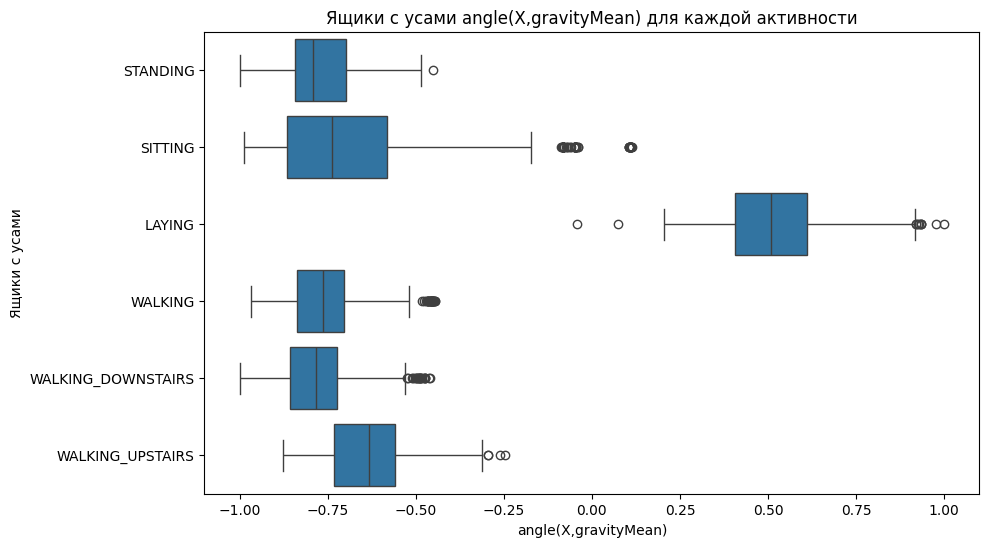

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x = 'angle(X,gravityMean)', y='Activity')
plt.title('Ящики с усами angle(X,gravityMean) для каждой активности')
plt.xlabel('angle(X,gravityMean)')
plt.ylabel('Ящики с усами')
plt.show()

Здесь выделяется лежачая активность, это обусловлено отличающимся положением тела в пространстве, что и отражается на графике для угла между осью Х и усредненнной гравитационной составляющей.

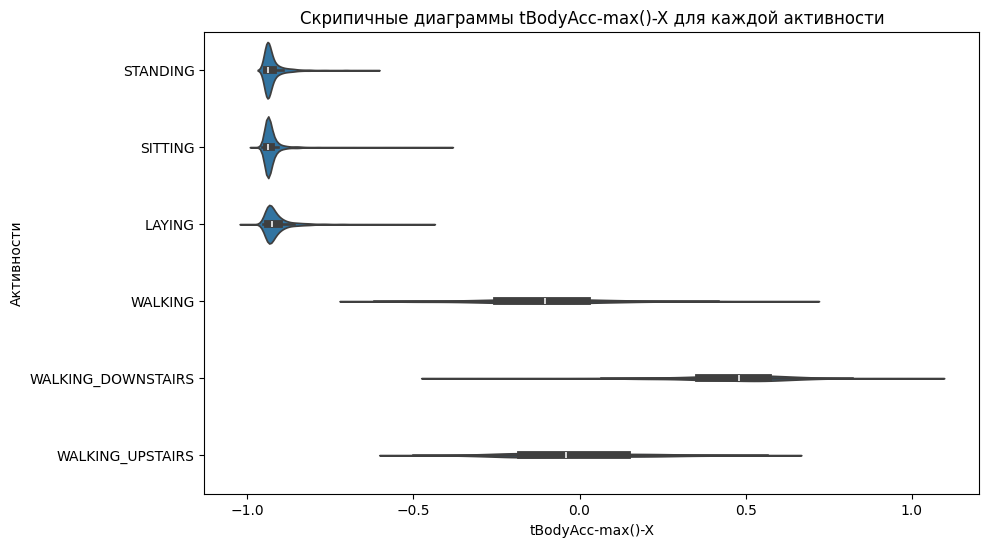

In [29]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=train, y='Activity' , x='tBodyAcc-max()-X')
plt.title('Скрипичные диаграммы tBodyAcc-max()-X для каждой активности')
plt.xlabel('tBodyAcc-max()-X')
plt.ylabel('Активности')
plt.show()

Здесь активности поделились на две группы, так как у динамических актиностей максимальное ускорение будет очевидно больше. Дальше всех от остальных здесь активность при спускании по лестнице, потому что у нее наибольшее ускорение, так как в таком виде активности нам помогает сила гравитации, которая и увеличивает максимальное значение ускорения.

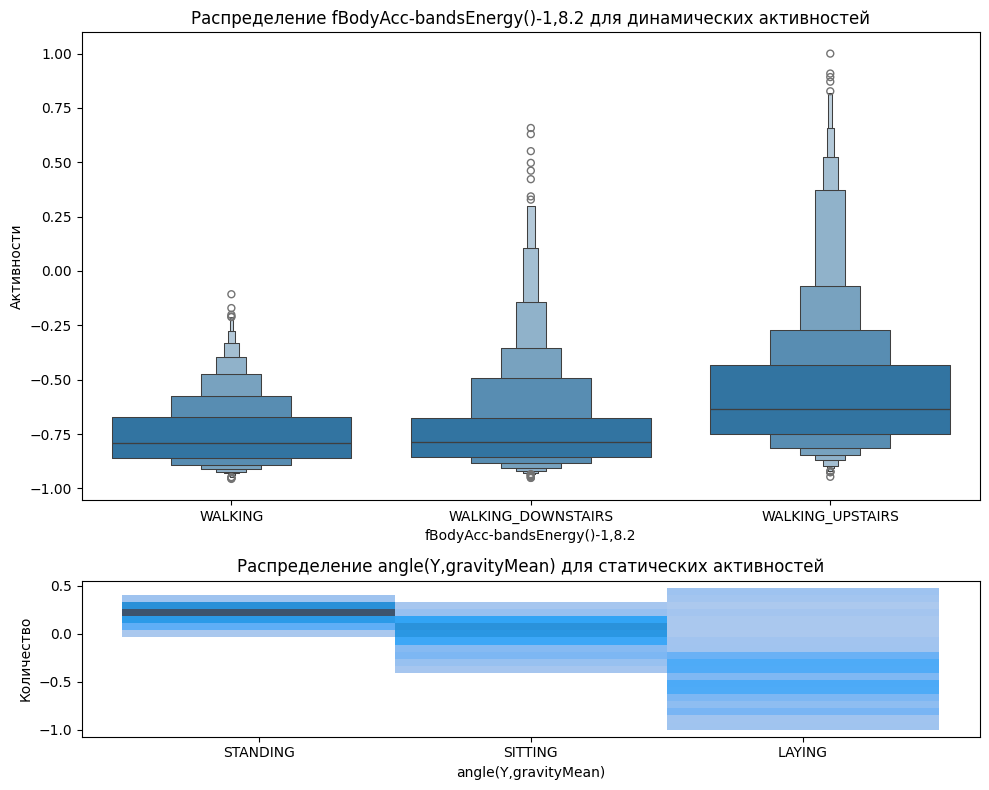

In [30]:
static_activities = ['SITTING', 'STANDING', 'LAYING']
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

static_data = train[train['Activity'].isin(static_activities)]
dynamic_data = train[train['Activity'].isin(dynamic_activities)]
fig, axs = plt.subplots(2, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

sns.boxenplot(data=dynamic_data, x='Activity', y='fBodyAcc-bandsEnergy()-1,8.2', ax=axs[0])
axs[0].set_title('Распределение fBodyAcc-bandsEnergy()-1,8.2 для динамических активностей')
axs[0].set_xlabel('fBodyAcc-bandsEnergy()-1,8.2')
axs[0].set_ylabel('Активности')
sns.histplot(data=static_data, x='Activity', y="angle(Y,gravityMean)", ax=axs[1], bins=20, kde=True)
axs[1].set_title('Распределение angle(Y,gravityMean) для статических активностей')
axs[1].set_xlabel('angle(Y,gravityMean)')
axs[1].set_ylabel('Количество')
plt.tight_layout()
plt.show()

На первом графике больше выделяется ходьба вверх по лестнице, так как она сопровождается большей энергией,необходимой для передвижения, что и отражено на графике.

На втором графике больше выделяется стоячая активность, ее диапазон ее значений уже. они сосредоточены в более малом отрезке, и соответвенно, их частота выше. Это связано с тем, что не так много вариантов углов по оси Y можно принимать человеку, который стоит, в отличие от сидячих и лежачих.

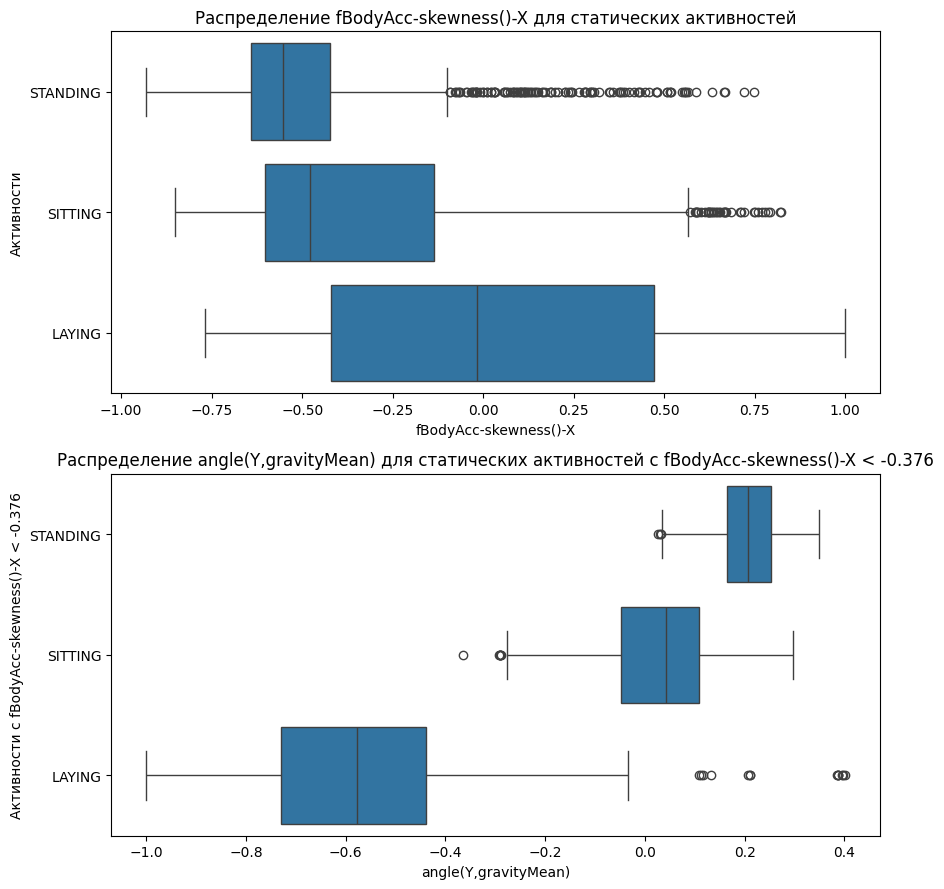

In [31]:
static_activities = ['SITTING', 'STANDING', 'LAYING']

left_graph_data = train[train['Activity'].isin(static_activities)]
right_graph_data = train[train['Activity'].isin(static_activities)]
right_graph_data = right_graph_data[right_graph_data['fBodyAcc-skewness()-X'] < -0.376]
fig, axs = plt.subplots(2, figsize=(9, 9))

sns.boxplot(data=left_graph_data, x='fBodyAcc-skewness()-X', y='Activity', ax=axs[0])
axs[0].set_title('Распределение fBodyAcc-skewness()-X для статических активностей')
axs[0].set_xlabel('fBodyAcc-skewness()-X')
axs[0].set_ylabel('Активности')
sns.boxplot(data=right_graph_data, x='angle(Y,gravityMean)', y='Activity', ax=axs[1])
axs[1].set_title('Распределение angle(Y,gravityMean) для статических активностей с fBodyAcc-skewness()-X < -0.376')
axs[1].set_xlabel('angle(Y,gravityMean)')
axs[1].set_ylabel('Активности с fBodyAcc-skewness()-X < -0.376')
plt.tight_layout()
plt.show()


На первом графике можно заметить, что у лежачей активности ассиметричноть частоты ускроения тела распределена вокруг нуля, что тоже интуитивно понятно, ведь большинство значений ускорений будет вокруг нуля, так как у лежачего человека вряд ли будет ускорение тела.

На втором графике тоже выделяется лежачая активность: ее угол между осью Y и гравитационной составляющей ускорения лежит в отрицательных значениях, в отличие от остальных, что тоже объясняется положением лежачего тела в пространстве. 

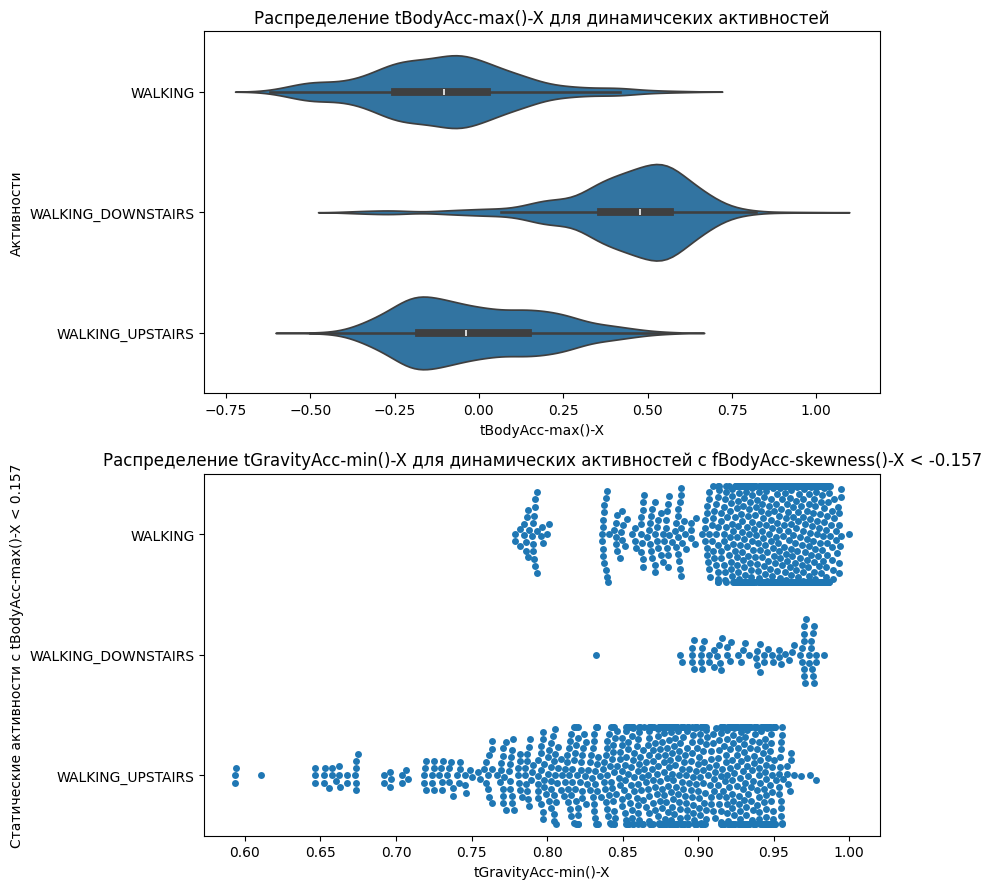

In [32]:
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

left_graph_data = train[train['Activity'].isin(dynamic_activities)]
right_graph_data = train[train['Activity'].isin(dynamic_activities)]
right_graph_data = right_graph_data[right_graph_data['tBodyAcc-max()-X'] < 0.157]
fig, axs = plt.subplots(2, figsize=(9, 9))

sns.violinplot(data=left_graph_data, x='tBodyAcc-max()-X', y='Activity', ax=axs[0])
axs[0].set_title('Распределение tBodyAcc-max()-X для динамичсеких активностей')
axs[0].set_xlabel('tBodyAcc-max()-X')
axs[0].set_ylabel('Активности')
sns.swarmplot(data=right_graph_data, x='tGravityAcc-min()-X', y='Activity', ax=axs[1])
axs[1].set_title('Распределение tGravityAcc-min()-X для динамических активностей с fBodyAcc-skewness()-X < -0.157')
axs[1].set_xlabel('tGravityAcc-min()-X')
axs[1].set_ylabel('Статические активности с tBodyAcc-max()-X < 0.157')
plt.tight_layout()
plt.show()


На первом графике выделяется спускании по лестнице, потому что там максимальное ускорение сосредоточено в положительной части графика, так как человек, спускающийся по лестнице начинает разгоняться сам по себе, а вот чтобы замедлиться ему надо как раз прилагать усилия. 

На втором графике можно отделить большую часть walking > 0.9, что можно связать опять же с вертикальным положением тела в пространстве, которое влияет на минимуму гравитационной составляющий по оси Х.

In [33]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=666, n_components=2)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_2_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y']),
    train['Activity']
], axis=1)

tsne = TSNE(random_state=666, n_components=3)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_3_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y', 'z']),
    train['Activity']
], axis=1)

CPU times: total: 9min 53s
Wall time: 1min 16s


In [ ]:
import plotly.express as px

fig = px.scatter(df_2_comp, x='x', y='y', color='Activity', title='Красивый график', labels={'x': 'x', 'y': 'y'}, width=610)
fig.update_traces(marker=dict(size=4))
fig.show()

In [36]:
fig = px.scatter_3d(df_3_comp, x='x', y='y', z = 'z', color='Activity', title='Красивый график 3Д', labels={'x': 'x', 'y': 'y', 'z': 'z'})
fig.update_traces(marker=dict(size=4))
fig.show()

In [37]:
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

def predict(df: pd.DataFrame):
    predictions = []  # Здесь будем хранить предсказания для каждой строки тестовых данных
    for index, row in df.iterrows():
        if row['angle(X,gravityMean)'] > 0.14:
            predictions.append('LAYING')
        elif row['tBodyAcc-max()-X'] > 0.25:
            predictions.append('WALKING_DOWNSTAIRS')
        elif row["Activity"] in dynamic_activities and row["tGravityAcc-min()-X"] > 0.88:
            predictions.append("WALKING")
        elif row["Activity"] in dynamic_activities and row["fBodyAcc-bandsEnergy()-1,8.2"] > -0.75:
            predictions.append("WALKING_UPSTAIRS")
        elif row["Activity"] not in dynamic_activities and row["angle(Y,gravityMean)"] > 0.15:
            predictions.append("STANDING")
        else:    
            predictions.append("SITTING")
    return predictions

def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

In [38]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.8200489662676823
Accuracy on test set => 0.7736681370885646
